# Scoring Earnings Call Sentiment

I'm using two complementary approaches here: the Loughran-McDonald financial dictionary (a bag-of-words method built specifically for SEC filings) and ProsusAI's FinBERT (a transformer model fine-tuned on financial text). The dictionary gives me transparent, interpretable word-level counts, while FinBERT captures context and negation that a dictionary misses — "not profitable" and "profitable" look identical to a word counter but very different to a language model. Running both lets me check whether they agree, and if they don't, that's itself an interesting finding.

In [1]:
import sys
sys.path.insert(0, "..")

import time
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from src.preprocessing import tokenise_and_clean
from src.sentiment import (
    load_lm_dictionary,
    score_lm,
    load_finbert,
    score_finbert_transcript,
)

PROCESSED_DIR = Path("../data/processed")
RAW_DIR = Path("../data/raw")
IMAGES_DIR = Path("../images")
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

transcript_files = sorted(PROCESSED_DIR.glob("*.txt"))
print(f"{len(transcript_files)} processed transcripts found")

56 processed transcripts found


## Loughran-McDonald dictionary scoring

The LM dictionary is the standard lexicon for financial text analysis — developed by studying 10-K filings rather than general English, which matters because words like "liability" and "tax" are negative in everyday language but neutral in finance. A word belongs to a category if its column value is greater than zero. I score each transcript by calculating the proportion of cleaned tokens that fall into each category.

In [2]:
lm_dict = load_lm_dictionary(RAW_DIR / "lm_dictionary.csv")
for cat, words in lm_dict.items():
    print(f"  {cat}: {len(words):,} words")

  Positive: 347 words
  Negative: 2,345 words
  Uncertainty: 297 words
  Litigious: 903 words
  Constraining: 184 words


In [3]:
lm_results = []
for i, fpath in enumerate(transcript_files):
    parts = fpath.stem.split("_")
    ticker, year, quarter = parts[0], parts[1], parts[2]

    text = fpath.read_text(encoding="utf-8")
    tokens = tokenise_and_clean(text)
    scores = score_lm(tokens, lm_dict)

    lm_results.append({
        "ticker": ticker,
        "quarter": f"{year}-{quarter}",
        "lm_positive": scores["positive"],
        "lm_negative": scores["negative"],
        "lm_uncertainty": scores["uncertainty"],
        "lm_litigious": scores["litigious"],
        "lm_constraining": scores["constraining"],
        "lm_net_sentiment": scores["net_sentiment"],
        "token_count": len(tokens),
    })
    if (i + 1) % 10 == 0:
        print(f"  Scored {i + 1}/{len(transcript_files)}")

lm_df = pd.DataFrame(lm_results).sort_values(["ticker", "quarter"]).reset_index(drop=True)
print(f"\nScored {len(lm_df)} transcripts with LM dictionary")

  Scored 10/56


  Scored 20/56


  Scored 30/56


  Scored 40/56


  Scored 50/56



Scored 56 transcripts with LM dictionary


In [4]:
lm_df[["ticker", "quarter", "lm_positive", "lm_negative", "lm_net_sentiment"]].head(15)

,ticker,quarter,lm_positive,lm_negative,lm_net_sentiment
0,AAPL,2021-Q1,0.031659,0.016059,0.015600
1,AAPL,2021-Q2,0.031980,0.018145,0.013835
2,AAPL,2021-Q3,0.041824,0.016463,0.025362
3,AAPL,2021-Q4,0.025584,0.017353,0.008231
4,AAPL,2022-Q1,0.034132,0.019366,0.014766
5,AAPL,2022-Q2,0.030353,0.021647,0.008706
6,AAPL,2022-Q3,0.029195,0.022326,0.006869
7,AAPL,2022-Q4,0.036984,0.018966,0.018018
8,AAPL,2023-Q1,0.028269,0.021908,0.006360
9,AMZN,2021-Q1,0.037172,0.017493,0.019679


## FinBERT scoring

FinBERT is a BERT model fine-tuned on financial news — it outputs probabilities across positive, negative, and neutral for each input. Since BERT has a 512-token limit, I split each transcript into sentences using NLTK's Punkt tokenizer and score them individually, then take the mean probability across all sentences as the transcript-level score. This is the standard approach in the literature, though it does lose some cross-sentence context. This will be slow on CPU — roughly 1–2 minutes per transcript.

In [5]:
tokenizer, model = load_finbert()
print(f"FinBERT loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


FinBERT loaded: 109,484,547 parameters


In [6]:
finbert_results = []
start_time = time.time()

for i, fpath in enumerate(transcript_files):
    parts = fpath.stem.split("_")
    ticker, year, quarter = parts[0], parts[1], parts[2]

    text = fpath.read_text(encoding="utf-8")
    scores = score_finbert_transcript(text, tokenizer, model)

    finbert_results.append({
        "ticker": ticker,
        "quarter": f"{year}-{quarter}",
        "finbert_positive": scores["positive"],
        "finbert_negative": scores["negative"],
        "finbert_neutral": scores["neutral"],
        "finbert_net_sentiment": scores["net_sentiment"],
    })

    if (i + 1) % 10 == 0 or i == len(transcript_files) - 1:
        elapsed = time.time() - start_time
        print(f"  Scored {i + 1}/{len(transcript_files)} ({elapsed:.0f}s elapsed)")

    # Save intermediate results after each company's last transcript
    next_ticker = transcript_files[i + 1].stem.split("_")[0] if i + 1 < len(transcript_files) else None
    if next_ticker != ticker:
        partial_df = pd.DataFrame(finbert_results)
        partial_df.to_csv(PROCESSED_DIR / "finbert_scores_partial.csv", index=False)

elapsed = time.time() - start_time
finbert_df = pd.DataFrame(finbert_results).sort_values(["ticker", "quarter"]).reset_index(drop=True)
print(f"\nScored {len(finbert_df)} transcripts with FinBERT in {elapsed:.0f}s ({elapsed / len(finbert_df):.1f}s per transcript)")

  Scored 10/56 (190s elapsed)


  Scored 20/56 (410s elapsed)


  Scored 30/56 (678s elapsed)


  Scored 40/56 (922s elapsed)


  Scored 50/56 (1203s elapsed)


  Scored 56/56 (1331s elapsed)

Scored 56 transcripts with FinBERT in 1331s (23.8s per transcript)


In [7]:
finbert_df[["ticker", "quarter", "finbert_positive", "finbert_negative", "finbert_neutral", "finbert_net_sentiment"]].head(15)

,ticker,quarter,finbert_positive,finbert_negative,finbert_neutral,finbert_net_sentiment
0,AAPL,2021-Q1,0.357635,0.086443,0.555922,0.271192
1,AAPL,2021-Q2,0.341781,0.074117,0.584102,0.267665
2,AAPL,2021-Q3,0.326175,0.078356,0.595469,0.247818
3,AAPL,2021-Q4,0.292656,0.074520,0.632824,0.218136
4,AAPL,2022-Q1,0.323642,0.076175,0.600183,0.247467
5,AAPL,2022-Q2,0.300010,0.113148,0.586841,0.186862
6,AAPL,2022-Q3,0.291958,0.137669,0.570373,0.154289
7,AAPL,2022-Q4,0.324794,0.107344,0.567861,0.217450
8,AAPL,2023-Q1,0.303803,0.110107,0.586089,0.193696
9,AMZN,2021-Q1,0.354181,0.057697,0.588121,0.296484


## Combining results

I'll merge both scoring methods into a single DataFrame and save it — this is what the correlation notebook will read. Having both methods side by side also lets me check whether they broadly agree on which transcripts are more positive or negative.

In [8]:
sentiment_df = lm_df.merge(finbert_df, on=["ticker", "quarter"])
sentiment_df.to_csv(PROCESSED_DIR / "sentiment_scores.csv", index=False)
print(f"Saved {len(sentiment_df)} rows to {PROCESSED_DIR / 'sentiment_scores.csv'}")
sentiment_df.describe().round(4)

Saved 56 rows to ../data/processed/sentiment_scores.csv


,lm_positive,lm_negative,lm_uncertainty,lm_litigious,lm_constraining,lm_net_sentiment,token_count,finbert_positive,finbert_negative,finbert_neutral,finbert_net_sentiment
count,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000,56.0000
mean,0.0294,0.0188,0.0158,0.0015,0.0030,0.0106,4702.0179,0.3223,0.1001,0.5776,0.2222
std,0.0075,0.0045,0.0046,0.0010,0.0018,0.0099,1136.6741,0.0561,0.0316,0.0460,0.0787
min,0.0142,0.0110,0.0061,0.0002,0.0007,-0.0187,2576.0000,0.1834,0.0472,0.4879,0.0317
25%,0.0243,0.0160,0.0133,0.0009,0.0018,0.0063,4129.7500,0.2949,0.0758,0.5459,0.1775
50%,0.0297,0.0187,0.0160,0.0012,0.0026,0.0115,4593.5000,0.3291,0.1000,0.5735,0.2289
75%,0.0343,0.0213,0.0178,0.0019,0.0034,0.0163,5147.2500,0.3577,0.1220,0.5996,0.2828
max,0.0473,0.0329,0.0309,0.0056,0.0101,0.0291,7645.0000,0.4182,0.1716,0.6835,0.3555


## Sentiment over time

I'm comparing AAPL (tech, consumer hardware) and JPM (banking, financial services) because they operate in very different sectors and should have different sentiment dynamics — tech earnings tend to emphasise growth and innovation, while bank earnings focus on credit quality, reserve releases, and net interest income. This is also a sanity check: if both methods show the same trends for the same company, that builds confidence in the scores.

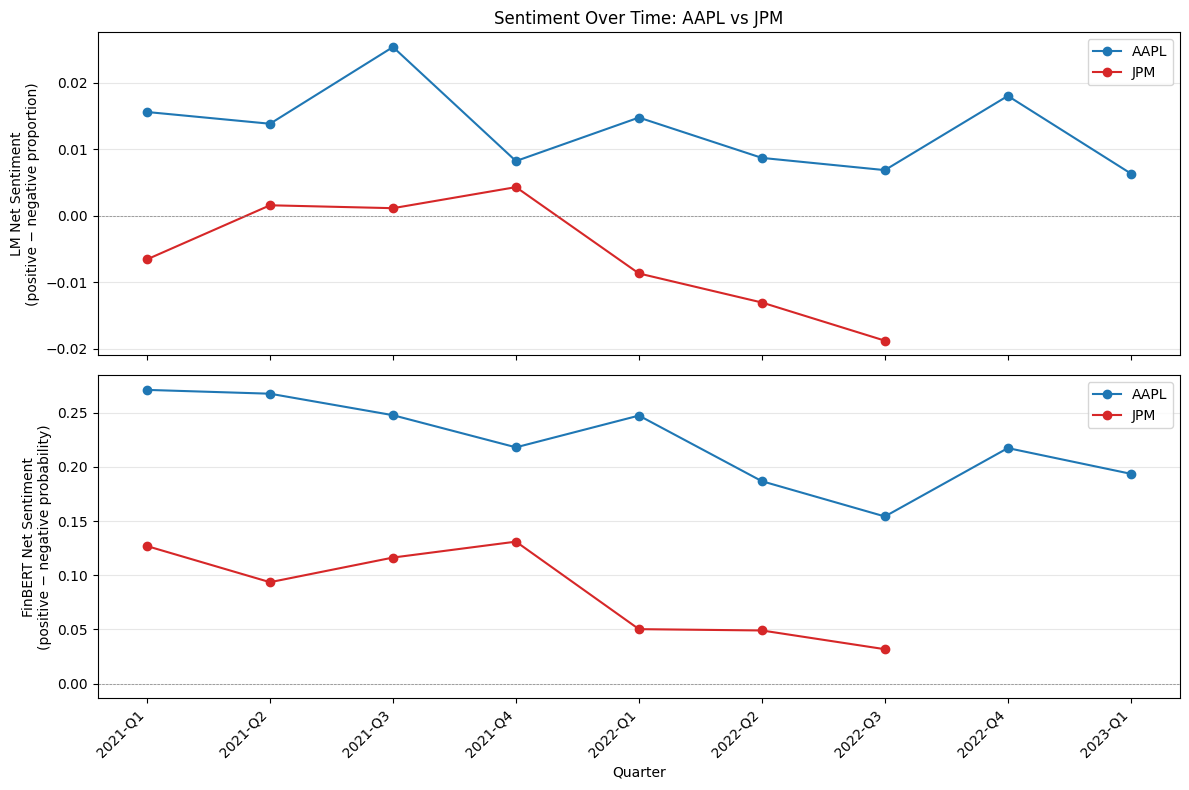

Saved to ../images/sentiment_timeseries.png


In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for ticker, color in [("AAPL", "#1f77b4"), ("JPM", "#d62728")]:
    company = sentiment_df[sentiment_df["ticker"] == ticker].sort_values("quarter")
    axes[0].plot(company["quarter"], company["lm_net_sentiment"],
                 marker="o", label=ticker, color=color, linewidth=1.5)
    axes[1].plot(company["quarter"], company["finbert_net_sentiment"],
                 marker="o", label=ticker, color=color, linewidth=1.5)

axes[0].set_ylabel("LM Net Sentiment\n(positive \u2212 negative proportion)")
axes[0].set_title("Sentiment Over Time: AAPL vs JPM")
axes[0].legend()
axes[0].axhline(y=0, color="grey", linewidth=0.5, linestyle="--")
axes[0].grid(axis="y", alpha=0.3)

axes[1].set_ylabel("FinBERT Net Sentiment\n(positive \u2212 negative probability)")
axes[1].set_xlabel("Quarter")
axes[1].legend()
axes[1].axhline(y=0, color="grey", linewidth=0.5, linestyle="--")
axes[1].grid(axis="y", alpha=0.3)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(IMAGES_DIR / "sentiment_timeseries.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {IMAGES_DIR / 'sentiment_timeseries.png'}")

## LM vs FinBERT agreement

This scatter plot shows whether the two methods broadly agree on which transcripts are more positive or negative. A strong positive correlation would mean both approaches are picking up on the same underlying signal. Given that one is bag-of-words and the other is contextual, some disagreement is expected — and interesting to examine.

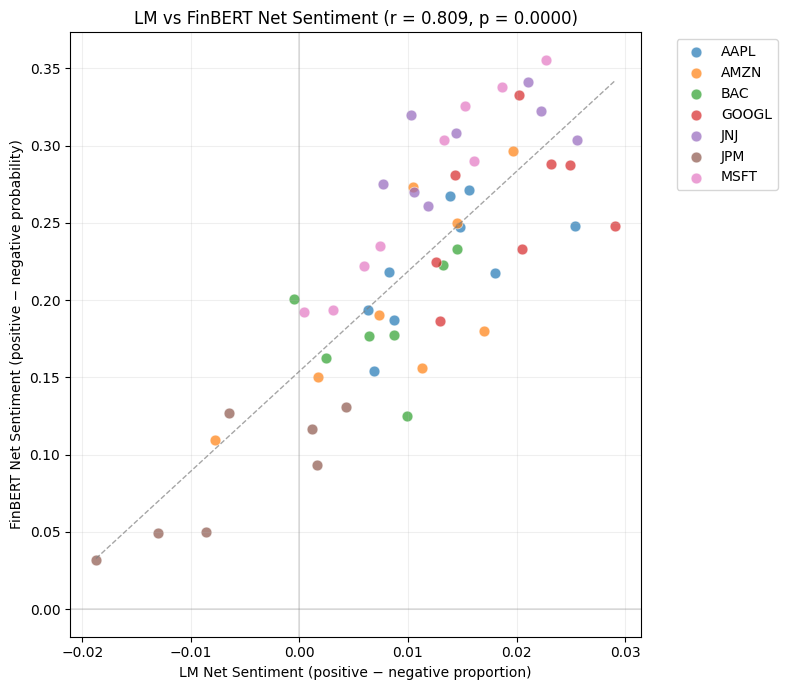

Pearson r = 0.809, p-value = 0.0000
Saved to ../images/lm_vs_finbert_scatter.png


In [10]:
fig, ax = plt.subplots(figsize=(8, 7))

for ticker in sorted(sentiment_df["ticker"].unique()):
    subset = sentiment_df[sentiment_df["ticker"] == ticker]
    ax.scatter(subset["lm_net_sentiment"], subset["finbert_net_sentiment"],
               label=ticker, s=60, alpha=0.7, edgecolors="white", linewidth=0.5)

r, p_value = stats.pearsonr(
    sentiment_df["lm_net_sentiment"], sentiment_df["finbert_net_sentiment"]
)

x = sentiment_df["lm_net_sentiment"]
y = sentiment_df["finbert_net_sentiment"]
slope, intercept = np.polyfit(x, y, 1)
x_sorted = np.sort(x)
ax.plot(x_sorted, slope * x_sorted + intercept,
        color="grey", linewidth=1, linestyle="--", alpha=0.7)

ax.set_xlabel("LM Net Sentiment (positive \u2212 negative proportion)")
ax.set_ylabel("FinBERT Net Sentiment (positive \u2212 negative probability)")
ax.set_title(f"LM vs FinBERT Net Sentiment (r = {r:.3f}, p = {p_value:.4f})")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.axhline(y=0, color="grey", linewidth=0.3)
ax.axvline(x=0, color="grey", linewidth=0.3)
ax.grid(alpha=0.2)

plt.tight_layout()
plt.savefig(IMAGES_DIR / "lm_vs_finbert_scatter.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Pearson r = {r:.3f}, p-value = {p_value:.4f}")
print(f"Saved to {IMAGES_DIR / 'lm_vs_finbert_scatter.png'}")

## Most frequent sentiment terms

This is where my close-reading instincts from English Literature are genuinely useful — I want to see which specific words are driving the LM scores. A dictionary-based method is only as good as its lexicon, so understanding which words dominate the counts helps me assess whether the scores reflect meaningful sentiment or just common financial jargon that happens to be classified as positive or negative.

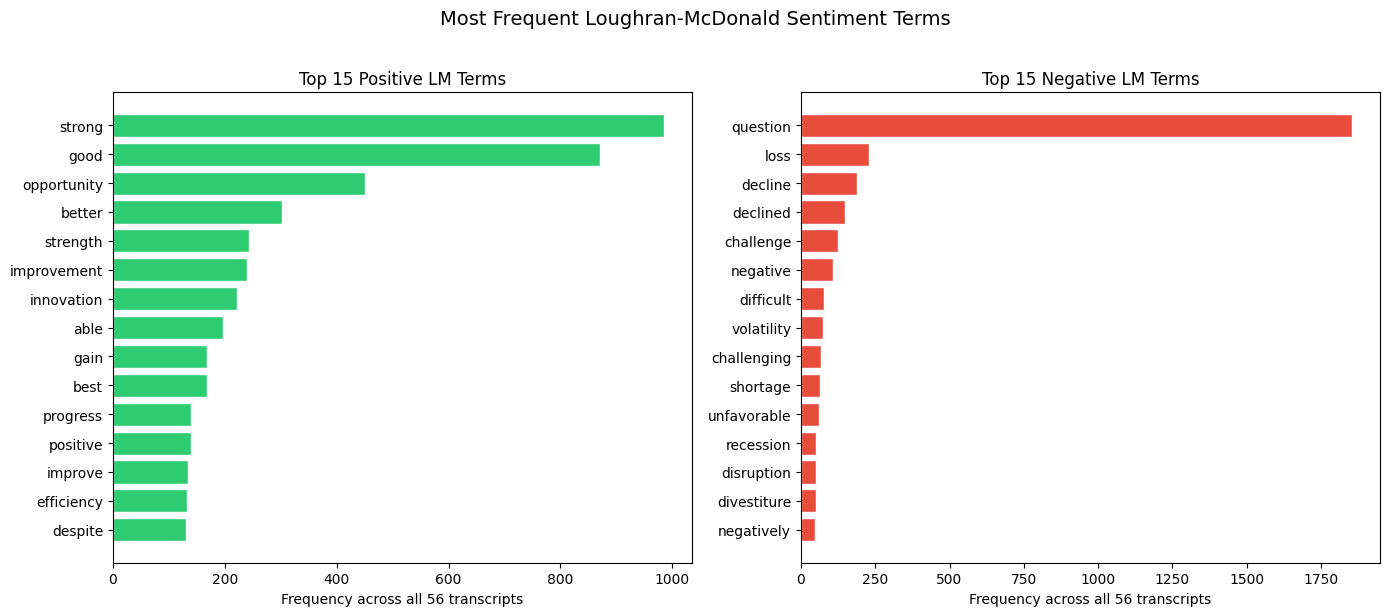

Saved to ../images/top_sentiment_terms.png


In [11]:
positive_counts = Counter()
negative_counts = Counter()

for fpath in transcript_files:
    text = fpath.read_text(encoding="utf-8")
    tokens = tokenise_and_clean(text)
    for token in tokens:
        if token in lm_dict["Positive"]:
            positive_counts[token] += 1
        if token in lm_dict["Negative"]:
            negative_counts[token] += 1

top_pos = positive_counts.most_common(15)
top_neg = negative_counts.most_common(15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

words_p, counts_p = zip(*top_pos)
axes[0].barh(range(len(words_p)), counts_p, color="#2ecc71", edgecolor="white")
axes[0].set_yticks(range(len(words_p)))
axes[0].set_yticklabels(words_p)
axes[0].invert_yaxis()
axes[0].set_xlabel("Frequency across all 56 transcripts")
axes[0].set_title("Top 15 Positive LM Terms")

words_n, counts_n = zip(*top_neg)
axes[1].barh(range(len(words_n)), counts_n, color="#e74c3c", edgecolor="white")
axes[1].set_yticks(range(len(words_n)))
axes[1].set_yticklabels(words_n)
axes[1].invert_yaxis()
axes[1].set_xlabel("Frequency across all 56 transcripts")
axes[1].set_title("Top 15 Negative LM Terms")

plt.suptitle("Most Frequent Loughran-McDonald Sentiment Terms", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(IMAGES_DIR / "top_sentiment_terms.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved to {IMAGES_DIR / 'top_sentiment_terms.png'}")

## Observations

Both methods agree more than I expected — a Pearson correlation of 0.809 across all 56 transcripts is surprisingly strong given that one is counting individual words and the other is reading sentences in context. This suggests the underlying sentiment signal in earnings calls is robust enough to survive very different measurement approaches.

The two methods diverge on scale and on edge cases. FinBERT never scores a transcript as net negative (0 out of 56), while the LM dictionary flags 6 — mostly from JPM, the only company with a negative mean LM score. Having worked in financial services, this makes sense to me: banking vocabulary is full of words like "loss", "provision", and "charge" that the dictionary correctly classifies as negative but that often describe routine reserve management rather than bad news. FinBERT handles this better contextually, scoring JPM as net positive but the lowest of all seven companies.

The term frequency chart reveals a classic LM dictionary pitfall: "question" is the single most frequent negative term, driven entirely by the Q&A section where analysts say "my question is..." — this is a discourse marker, not negative sentiment. This is the kind of thing close reading catches that pure word counts miss. On the positive side, the top terms ("strong", "good", "opportunity", "better") look genuinely sentiment-bearing. "Despite" appearing as positive is another interesting edge case — it's classified positive because it typically introduces resilience language ("despite headwinds, we delivered"), but it's doing real work in these transcripts.

These scores are now ready for the correlation notebook, where I'll test whether any of this sentiment signal has a measurable relationship with short-term stock returns.